In [1]:
!pip install pydicom

     |████████████████████████████████| 7.1MB 5.0MB/s 


In [0]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch > /dev/null 2>&1 # Install segmentations_models.pytorch, with no bash output.

In [3]:
import os
import numpy as np
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pydicom
import pandas as pd
import torchvision
import torch.utils.data
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch import Tensor
from __future__ import print_function, division
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.nn.functional as F
import random
import sys
from tqdm import tqdm
import time
###
from __future__ import print_function, division
import os
import numpy as np
from PIL import Image
import glob
#import SimpleITK as sitk
from torch import optim
import torch.utils.data
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.nn
import torchvision
import matplotlib.pyplot as plt
import natsort
from torch.utils.data.sampler import SubsetRandomSampler
import torchsummary
#from torch.utils.tensorboard import SummaryWriter
#from tensorboardX import SummaryWriter
import segmentation_models_pytorch as smp
import shutil
import random
import time
torch.manual_seed(0)
#####################
import os
import cv2
import pdb
import time
import warnings
import random
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import StratifiedKFold
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, Dataset, sampler
from matplotlib import pyplot as plt
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.torch import ToTensor
warnings.filterwarnings("ignore")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#Data set

In [0]:
def show_dcm_info(dataset):
    print("Filename.........:", file_path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()


Filename.........: /content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/1.2.276.0.7230010.3.1.4.8323329.4881.1517875185.250249.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: b19bd04d-70ef-488c-9736-b672a0ff0d46, 
Patient id..........: b19bd04d-70ef-488c-9736-b672a0ff0d46
Patient's Age.......: 64
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: AP
Image size.......: 1024 x 1024, 158506 bytes
Pixel spacing....: ['0.139', '0.139']


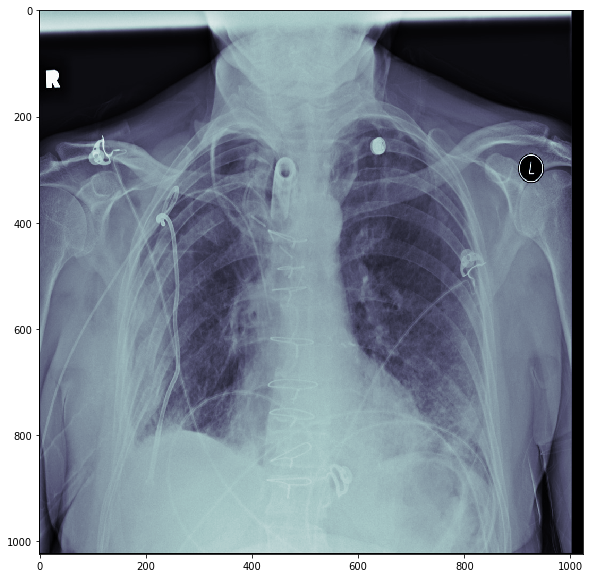

In [5]:
i= 0 
for file_path in glob.glob("/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm"):
    i=i+1
    dataset = pydicom.dcmread(file_path)
    show_dcm_info(dataset)
    plot_pixel_array(dataset)
    if(i==1):
      break # Comment this out to see all

In [0]:
##decoding the mask and specify it in the image
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]
    current_position = 0
    if(lengths.shape[0]>1):
        for index, start in enumerate(starts):
            current_position += start
            mask[current_position:current_position+lengths[index]] = 255
            current_position += lengths[index]

    return mask.reshape(width, height)


# #################################################
#################################################    
# start = 75   # Starting index of images
# num_img = 25 # Total number of images to show


# df = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', header=None, index_col=0)

# fig, ax = plt.subplots(nrows=1, ncols=num_img, sharey=True, figsize=(num_img*10,10))
# for q, file_path in enumerate(glob.glob('/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm')[start:start+num_img]):
#     dataset = pydicom.dcmread(file_path)
#     #print(file_path.split('/')[-1][:-4])
#     ax[q].imshow(dataset.pixel_array, cmap=plt.cm.bone)
#     # print(len(df.loc[file_path.split('/')[-1][:-4],1]))
#     # if df.loc[file_path.split('/')[-1][:-4],1] != '-1':
#     if len(df.loc[file_path.split('/')[-1][:-4],1]) > 4 :
#         mask = rle2mask(df.loc[file_path.split('/')[-1][:-4],1], 1024, 1024).T
#         ax[q].set_title('See Marker')
#         ax[q].imshow(mask, alpha=0.3, cmap="Reds")
#     # else:
#     #     ax[q].set_title('Nothing to see')




#segmentation task( area of pneumethorax )

In [0]:
train_glob = '/content/drive/My Drive/CMPUT 617(PROJECT)/project/new train/*.dcm'
train_fns = sorted(glob.glob(train_glob))[0:2000]
df_full = pd.read_csv('/content/drive/My Drive/CMPUT 617(PROJECT)/project/train-rle.csv', index_col='ImageId')
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(16, 16))
#######################################################
#Passing the Dataset of Images and Labels
#######################################################
im_height = 1024
im_width = 1024
im_chan = 1
# Get train images and masks
X1_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
X_train = np.zeros((len(train_fns), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_fns), im_height, im_width, 1), dtype=np.bool)
print('Getting train images and masks ... ')
sys.stdout.flush()
for n, _id in tqdm(enumerate(train_fns), total=len(train_fns)):
    dataset1 = pydicom.read_file(_id)
    dataset  = clahe.apply(dataset1.pixel_array)
    X_train[n] = np.expand_dims(dataset, axis=2)
    try:
        if '-1' in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
            Y_train[n] = np.zeros((1024, 1024, 1))
        else:
            if type(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']) == str:
                Y_train[n] = np.expand_dims(rle2mask(df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels'], 1024, 1024), axis=2)
            else:
                Y_train[n] = np.zeros((1024, 1024, 1))
                for x in df_full.loc[_id.split('/')[-1][:-4],' EncodedPixels']:
                    Y_train[n] =  Y_train[n] + np.expand_dims(rle2mask(x, 1024, 1024), axis=2)
    except KeyError:
        print(f"Key {_id.split('/')[-1][:-4]} without mask, assuming healthy patient.")
        Y_train[n] = np.zeros((1024, 1024, 1)) # Assume missing masks are empty masks.

print('Done!')
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_big_new', X_train)
np.save('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_trian_big_new', Y_train)

Getting train images and masks ... 


Key 1.2.276.0.7230010.3.1.4.8323329.12062.1517875237.179186 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.13378.1517875244.961609 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.13415.1517875245.218707 without mask, assuming healthy patient.
Key 1.2.276.0.7230010.3.1.4.8323329.13620.1517875246.884737 without mask, assuming healthy patient.

Done!


In [6]:
X_train_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_train_big.npy')
Y_train_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_train_big.npy')
X_test_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/X_test_big.npy')
Y_test_1 = np.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/Y_test_big.npy')
# im_height = 128
# im_width = 128

############################ommitting healthy patients

j=0
k=0
for i in range (0,len(X_train_1)):
  if( np.count_nonzero(Y_train_1[i][:][:][:]) > 1 ):
      j=j+1

print(j)

for i in range (0,len(X_test_1)):
  if( np.count_nonzero(Y_test_1[i][:][:][:]) > 1 ):
      k=k+1

print(k)

X_train_2 = np.zeros((j,1024,1024,1))
Y_train_2= np.zeros((j,1024,1024,1)) 
X_test_2 = np.zeros((k,1024,1024,1))
Y_test_2 = np.zeros((k,1024,1024,1))

j=-1
k=-1

for i in range (0,len(X_train_1)):
  if( np.count_nonzero(Y_train_1[i][:][:][:]) > 1 ):
      k=k+1
      X_train_2[k][:][:][:]= X_train_1[i][:][:][:] 
      Y_train_2[k][:][:][:]= Y_train_1[i][:][:][:] 

for i in range (0,len(X_test_1)):
  if( np.count_nonzero(Y_test_1[i][:][:][:]) > 1 ):
      j=j+1
      X_test_2[j][:][:][:]= X_test_1[i][:][:][:] 
      Y_test_2[j][:][:][:]= Y_test_1[i][:][:][:] 


# X_train = X_train.reshape((-1, im_height, im_width, 1))
# Y_train = Y_train.reshape((-1, im_height, im_width, 1))
# X_valid = X_valid.reshape((-1, im_height, im_width, 1))
# Y_valid = Y_valid.reshape((-1, im_height, im_width, 1))



#####################

X_train_2 = np.transpose(X_train_2, (0,3,2,1))
Y_train_2 =np.transpose(Y_train_2 , (0,3,2,1))
X_test_2 =np.transpose(X_test_2, (0,3,2,1))
Y_test_2= np.transpose(Y_test_2, (0,3,2,1))

X_train_3  = np.repeat(X_train_2, 3, axis=1)
X_test_3  = np.repeat(X_test_2, 3, axis=1)


# X_train = torch.nn.functional.interpolate(Tensor(X_train_3), size=[512,512], mode='nearest', align_corners=None)
# Y_train = torch.nn.functional.interpolate(Tensor(Y_train_2), size=[512,512], mode='nearest', align_corners=None)
# X_test= torch.nn.functional.interpolate(Tensor(X_test_3), size=[512,512], mode='nearest', align_corners=None)
# Y_test = torch.nn.functional.interpolate(Tensor(Y_test_2), size=[512,512], mode='nearest', align_corners=None)


dataset = TensorDataset( Tensor(X_train_3), Tensor(Y_train_2) )
dataset2 =  TensorDataset( Tensor(X_test_3), Tensor(Y_test_2))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=1, shuffle=True)
print(X_test_3 .shape)





228
47
(47, 3, 1024, 1024)


In [0]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [0]:
def run_length_decode(rle, height=1024, width=1024, fill_value=1):
    component = np.zeros((height, width), np.float32)
    component = component.reshape(-1)
    rle = np.array([int(s) for s in rle.strip().split(' ')])
    rle = rle.reshape(-1, 2)
    start = 0
    for index, length in rle:
        start = start+index
        end = start+length
        component[start: end] = fill_value
        start = end
    component = component.reshape(width, height).T
    return component

def run_length_encode(component):
    component = component.T.flatten()
    start = np.where(component[1:] > component[:-1])[0]+1
    end = np.where(component[:-1] > component[1:])[0]+1
    length = end-start
    rle = []
    for i in range(len(length)):
        if i == 0:
            rle.extend([start[0], length[0]])
        else:
            rle.extend([start[i]-end[i-1], length[i]])
    rle = ' '.join([str(r) for r in rle])
    return rle

In [0]:
class SIIMDataset(Dataset):
    def __init__(self, df, fnames, data_folder, size, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.size = size
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, size, mean, std)
        self.gb = self.df.groupby('ImageId')
        self.fnames = fnames

    def __getitem__(self, idx):
        image_id = self.fnames[idx]
        df = self.gb.get_group(image_id)
        annotations = df[' EncodedPixels'].tolist()
        image_path = os.path.join(self.root, image_id + ".png")
        image = cv2.imread(image_path)
        mask = np.zeros([1024, 1024])
        if annotations[0] != ' -1':
            for rle in annotations:
                mask += run_length_decode(rle)
        mask = (mask >= 1).astype('float32') # for overlap cases
        augmented = self.transforms(image=image, mask=mask)
        image = augmented['image']
        mask = augmented['mask']
        return image, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, size, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
#                 HorizontalFlip(),
                ShiftScaleRotate(
                    shift_limit=0,  # no resizing
                    scale_limit=0.1,
                    rotate_limit=10, # rotate
                    p=0.5,
                    border_mode=cv2.BORDER_CONSTANT
                ),
#                 GaussNoise(),
            ]
        )
    list_transforms.extend(
        [
            Resize(size, size),
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )

    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    fold,
    total_folds,
    data_folder,
    df_path,
    phase,
    size,
    mean=None,
    std=None,
    batch_size=8,
    num_workers=4,
):
    df_all = pd.read_csv(df_path)
    df = df_all.drop_duplicates('ImageId')
    df_with_mask = df[df[" EncodedPixels"] != " -1"]
    df_with_mask['has_mask'] = 1
    df_without_mask = df[df[" EncodedPixels"] == " -1"]
    df_without_mask['has_mask'] = 0
    df_without_mask_sampled = df_without_mask.sample(len(df_with_mask), random_state=69) # random state is imp
    df = pd.concat([df_with_mask, df_without_mask_sampled])
    
    #NOTE: equal number of positive and negative cases are chosen.
    
    kfold = StratifiedKFold(total_folds, shuffle=True, random_state=69)
    train_idx, val_idx = list(kfold.split(df["ImageId"], df["has_mask"]))[fold]
    train_df, val_df = df.iloc[train_idx], df.iloc[val_idx]
    df = train_df if phase == "train" else val_df
    # NOTE: total_folds=5 -> train/val : 80%/20%
    
    fnames = df['ImageId'].values
    
    image_dataset = SIIMDataset(df_all, fnames, data_folder, size, mean, std, phase)

    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [0]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))


class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()


class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [0]:
def predict(X, threshold):
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

#         dice_neg = np.nan_to_num(dice_neg.mean().item(), 0)
#         dice_pos = np.nan_to_num(dice_pos.mean().item(), 0)
#         dice = dice.mean().item()

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice)
        self.dice_pos_scores.extend(dice_pos)
        self.dice_neg_scores.extend(dice_neg)
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f | IoU: %0.4f" % (epoch_loss, dice, dice_neg, dice_pos, iou))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]


def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou

In [12]:
model = smp.Unet("resnet50", encoder_weights="imagenet", activation=None)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 30.8MB/s]


In [0]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.fold = 1
        self.total_folds = 5
        self.num_workers = 6
        self.batch_size = {"train": 4, "val": 4}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 40
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = MixedLoss(10.0, 2.0)
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True

        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = train_loader
        running_loss = 0.0
        total_batches = len(dataloader)
#         tk0 = tqdm(dataloader, total=total_batches)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader):
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
#             tk0.set_postfix(loss=(running_loss / ((itr + 1))))
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            val_loss = self.iterate(epoch, "val")
            self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(model,'/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt')
            print()

In [16]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 20:43:50
Loss: 3.8985 | dice: 0.0584 | dice_neg: nan | dice_pos: 0.0584 | IoU: 0.0326
Starting epoch: 0 | phase: val | ⏰: 20:44:37


RuntimeError: ignored

In [0]:
class TestDataset(Dataset):
    def __init__(self, root, df, size, mean, std, tta=4):
        self.root = root
        self.size = size
        self.fnames = list(df["ImageId"])
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                Resize(size, size),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname + ".png")
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return images

    def __len__(self):
        return self.num_samples

def post_process(probability, threshold, min_size):
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((1024, 1024), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [16]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available. Training on CPU')
else:
    print('CUDA is available. Training on GPU')

device = torch.device("cuda:0" if train_on_gpu else "cpu")

CUDA is available. Training on GPU


tensor(0.1735, grad_fn=<DivBackward0>)


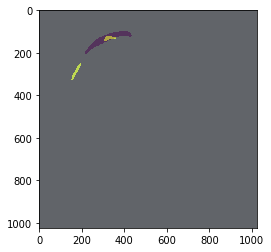

tensor(0.0019, grad_fn=<DivBackward0>)


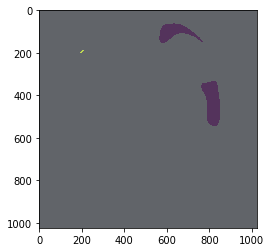

tensor(0.0029, grad_fn=<DivBackward0>)


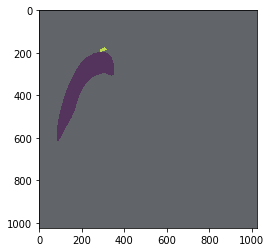

tensor(0.0026, grad_fn=<DivBackward0>)


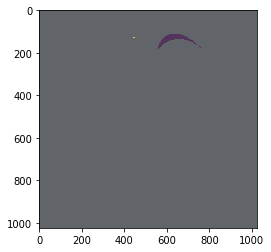

tensor(0.0011, grad_fn=<DivBackward0>)


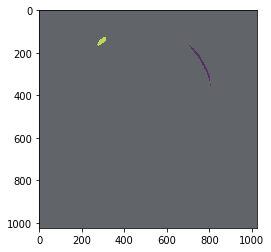

tensor(0.4288, grad_fn=<DivBackward0>)


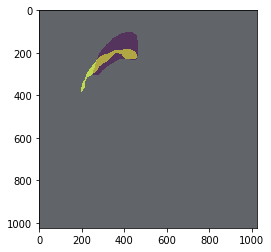

tensor(0.0058, grad_fn=<DivBackward0>)


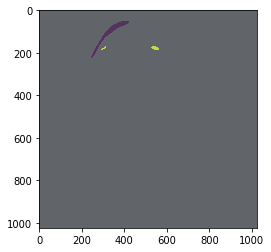

tensor(0.0021, grad_fn=<DivBackward0>)


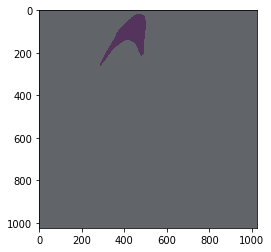

tensor(0.1114, grad_fn=<DivBackward0>)


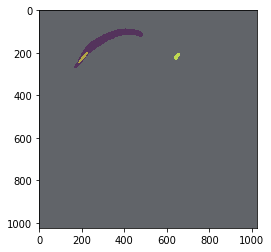

tensor(0.0353, grad_fn=<DivBackward0>)


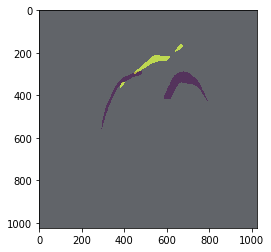

tensor(0.6044, grad_fn=<DivBackward0>)


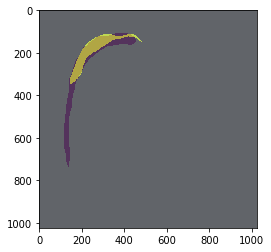

tensor(0.0018, grad_fn=<DivBackward0>)


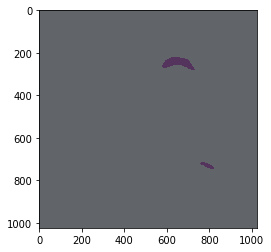

tensor(0.0019, grad_fn=<DivBackward0>)


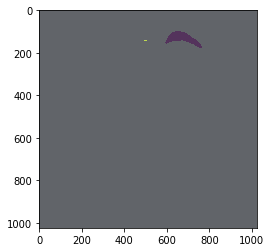

tensor(0.0013, grad_fn=<DivBackward0>)


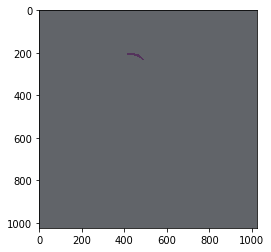

tensor(0.0016, grad_fn=<DivBackward0>)


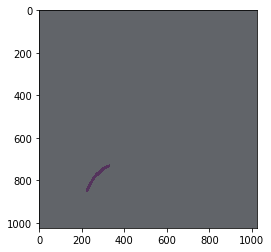

tensor(0.0022, grad_fn=<DivBackward0>)


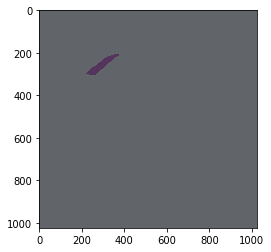

tensor(0.2072, grad_fn=<DivBackward0>)


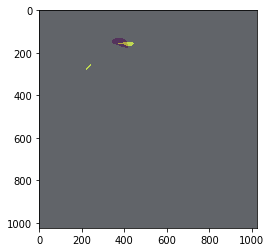

tensor(0.0020, grad_fn=<DivBackward0>)


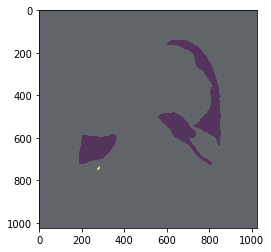

tensor(0.0015, grad_fn=<DivBackward0>)


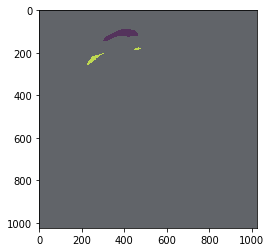

tensor(0.0018, grad_fn=<DivBackward0>)


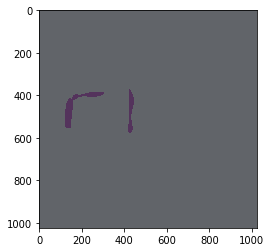

tensor(0.0018, grad_fn=<DivBackward0>)


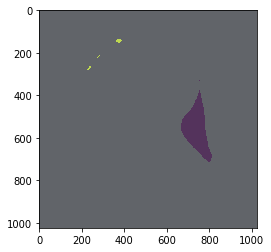

tensor(0.0017, grad_fn=<DivBackward0>)


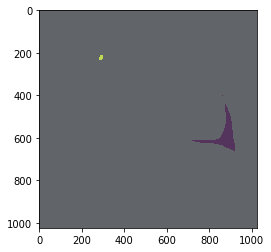

tensor(0.0023, grad_fn=<DivBackward0>)


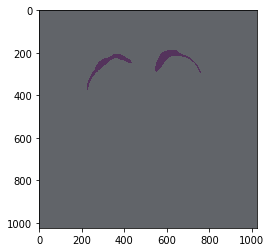

tensor(0.0018, grad_fn=<DivBackward0>)


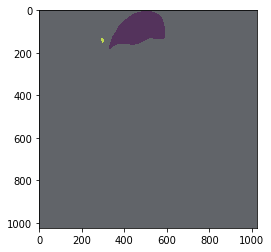

tensor(0.0216, grad_fn=<DivBackward0>)


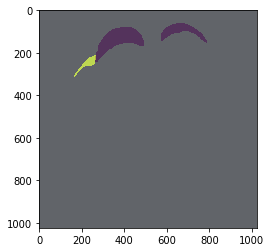

tensor(0.0025, grad_fn=<DivBackward0>)


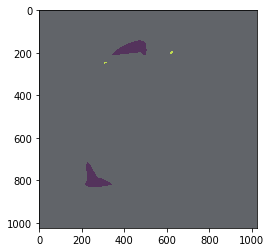

tensor(0.3808, grad_fn=<DivBackward0>)


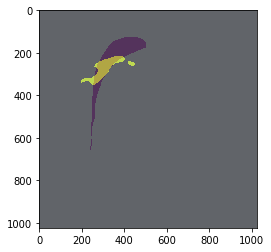

tensor(0.0026, grad_fn=<DivBackward0>)


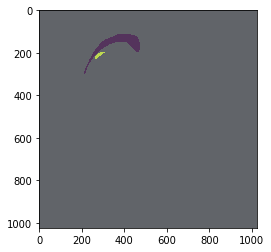

tensor(0.0201, grad_fn=<DivBackward0>)


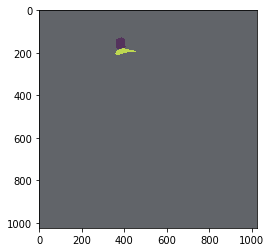

In [17]:
model_trainer = Trainer(model)
model = model_trainer.net # get the model from model_trainer object
model.eval()
model = torch.load('/content/drive/My Drive/CMPUT 617(PROJECT)/project/MODEL.pt', map_location=lambda storage, loc: storage)
torch.no_grad() #to increase the validation process uses less memory
j=1
accuracy = 0
for x1, y1 in test_loader:
    # x1, y1 = x1.to(device), y1.to(device)
    # # print(y1.shape)
    # # print(y1)
    y_pred1 = model(x1)
    lossL = dice_loss( y_pred1.cuda(),y1.cuda())    # Dice_loss Used
    # print(lossL)
    j=j+1
    print(lossL)

    out = (y_pred1 > 0.5).float() * 1
    plt.figure(1)
    plt.imshow(out.squeeze(1).squeeze(0).detach().cpu())
    plt.imshow(y1.squeeze(1).squeeze(0).detach().cpu(),"Accent",alpha=0.5)
    plt.show()
    # accuracy = lossL + accuracy
    # plt.figure(2)
    # plt.imshow(y1.squeeze(1).squeeze(0).detach().cpu())
    # plt.show()
    if(j==30):
      break
